PGL monitor calibration


In [36]:
%load_ext autoreload
%autoreload 2

# library imports
from matplotlib import pyplot as plt
import numpy as np

# Load PGL libraries and start a PGL window
from pgl import pgl as pglLibrary
pgl = pglLibrary()

# close any existing windows
pgl.cleanUp()

# open a new window
pgl.open(0,800,600)
pgl.visualAngle(57, 60,40)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
================================ pglBase: init =================================
(pgl:checkOS) Python version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:35:20) [Clang 16.0.6 ]
(pgl:checkOS) Running on MacBook Pro (MacBookPro18,3) with macOS version: 26.2
(pgl:checkOS) Apple M1 Pro Cores: 8 (6 performance and 2 efficiency) Memory: 32 GB
(pgl:checkOS) GPU: Apple M1 Pro (Built-In) 14 cores, Metal 4 support
(pgl:checkOS)   Color LCD [Main Display]: 3024 x 1964 Retina (Built-in Liquid Retina XDR Display) GammaTable size: 1024
(pglBase) Main library instance created
(pglBase:shutdownAll) Shutting down mglMetal process: 41162
(pglBase:removeOrphanedSockets) Removing orphaned socket: /Users/justin/Library/Containers/gru.mglMetal/Data/pglMetal.socket.20260210_210940.TiBdK1ewXA
(pglBase:removeOrphanedSockets) Removed 1 orphaned sockets
================================= pglBase:open ===========

Now, let's measure the temporal frequency response of the display using a photodiode. For this, you will need to do the following:

- Connect photodiode to Hamamatsu Amp via the BNC connector
- Connect the output of Hamamastu Amp to the Labjack A0 input
- Connect the USB of the Labjack to the computer
- Position the photodiode so that it is on the monitor


The following code will init the LabJack. Take a look at the output and make sure that it does not report an error loading LabJack.

In [24]:
# import pglLabJack and create an instance
from pgl import pglLabJack
pglLabJack = pglLabJack()

(pglDevice) Cleaning up device of type LabJack
(pglLabJack) Opened T7 LabJack device via USB connection.
             serialNumber: 470040275 ipAddress: 0 port: 0 maxBytesPerMB: 64


We now will flicker the screen and display the output

(pglLabJack:setupDigitalOutput) FIO0 configured as output, set to LOW
(pgl:_resolution:getResolution) Display 1/2: 1920x1200 60Hz 32bits
(pglLabJack:getCycles) Ignoring first 0.5s (500 samples)


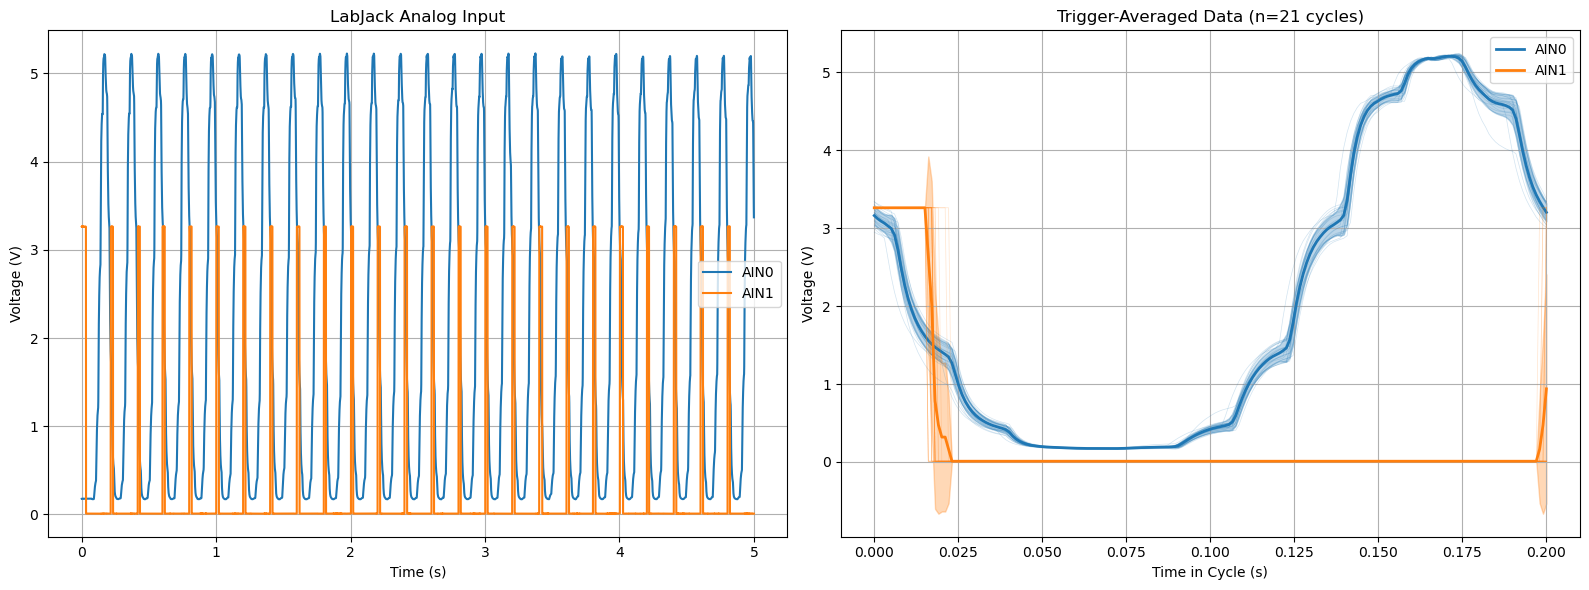

cycleStartFlushTime): [array(0.), array(97920.79664721), array(97920.99681313), array(97921.18029858), array(97921.3804645), array(97921.58063038), array(97921.78079625), array(97921.98096217), array(97922.18112804), array(97922.38129396), array(97922.58145979), array(97922.78162567), array(97922.98179158), array(97923.18195754), array(97923.38212342), array(97923.58228933), array(97923.78245521), array(97923.98262108), array(97924.182787), array(97924.38295288), array(97924.58311879), array(97924.78328471), array(97924.98345058), array(97925.1836165), array(97925.38378242)]
cycleStartTime: [1770773402.376234, 1770773402.5942762, 1770773402.795119, 1770773402.97842, 1770773403.178602, 1770773403.3784032, 1770773403.5788858, 1770773403.7797382, 1770773403.978136, 1770773404.178595, 1770773404.3804889, 1770773404.5790021, 1770773404.779346, 1770773404.980051, 1770773405.180465, 1770773405.3798559, 1770773405.580253, 1770773405.780473, 1770773405.9842901, 1770773406.18122, 1770773406.3812

In [32]:
# set stimulus duration in seconds
stimulusDuration = 5

# open as full screen
#pgl.fullScreen(True)
#pgl.waitSecs(0.5)

# setup digital output for sync pulse (optional, but recommended for precise timing)
pglLabJack.setupDigitalOutput(channel=0)
pglLabJack.digitalOutput(0)

startTime = pgl.getSecs()
pglLabJack.startAnalogRead(duration=stimulusDuration, channels=['AIN0','AIN1'])

# arrays of timestamps
cycleStartTime = []
cycleStartFlushTime = []
flushTime = []

# frequency of the flickering stimulus in Hz
temporalFrequency = 5

# start flickering stimulus
flicker = pgl.flicker(pgl, temporalFrequency=temporalFrequency, type='sine', phase=-90)

#display first frame with a synchronization pulse
timestamp = pglLabJack.digitalOutput(1)
flicker.display()

# keep timestamps
flushTime.append(pgl.flush())
cycleStartTime.append(timestamp)
cycleStartFlushTime.append(flushTime[-1])

while pgl.getSecs() - startTime < stimulusDuration:
    # display the stimulus, which returns True at the beginning of each cycle and False otherwise
    newCycle = flicker.display()
    # set the digital ouptut high if this frame is the beginning of a cycle
    timestamp = pglLabJack.digitalOutput(newCycle)
    # flush the screen, recording the time of each flush for later analysis
    flushTime.append(pgl.flush())
    # if this was a beginning of cycle, then keep track of the cycle start time and flush time
    if newCycle:
        cycleStartTime.append(timestamp)
        cycleStartFlushTime.append(flushTime[-1])

# stop analog read
time, data = pglLabJack.stopAnalogRead()

# close full screen
pgl.fullScreen(False)

# plot data
#pglLabJack.plotAnalogRead(time, data, cycleLen=1/temporalFrequency)
pglLabJack.plotAnalogRead(time, data, digitalSyncChannel=1, digitalSyncThreshold=2, ignoreInitial=0.5)

# compute average delay between digital sync pulse and screen refresh
syncDelays = np.array(cycleStartFlushTime) - np.array(cycleStartTime)
print(f"cycleStartFlushTime): {cycleStartFlushTime}")
print(f"cycleStartTime: {cycleStartTime}")
print(f"Average delay between digital sync pulse and screen refresh: {np.mean(syncDelays)*1000:.2f} ms (n={len(syncDelays)})")

In [ ]:
print(cycleStartFlushTime)
print(cycleStartTime)

Read the gamma table and display it

In [ ]:
# Read the gamma table
gammaTable = pgl.getGammaTable(0)

# display it
plt.plot(gammaTable[0], label='Red')
plt.plot(gammaTable[1], label='Green')
plt.plot(gammaTable[2], label='Blue')
plt.title('Gamma Table')
plt.xlabel('Input Value')
plt.ylabel('Output Value')
plt.legend()
plt.show()

Set gamma table

In [ ]:
# Get the size of the gamma table
displayNumber = 0
tableSize = pgl.getGammaTableSize(displayNumber)
print(f"Gamma table size: {tableSize}")

# create a gamma table
gamma = 1
lin = np.linspace(0, 1, tableSize, dtype=np.float32)
red = lin ** gamma
green = lin ** gamma
blue = lin ** gamma

# set it
pgl.setGammaTable(displayNumber, red, green, blue)

Setup minolta device

- Connect ...

In [ ]:
# initialize minolta calibration device
from pgl import pglCalibrationDeviceMinolta, pglCalibration
pglMinolta = pglCalibrationDeviceMinolta()

Make a measurement

In [ ]:
pglMinolta.measure()

Run a calibration

In [ ]:
# initialize the calibration with the minolta device
pglCal = pglCalibration(pgl, pglMinolta)

# Run the calibration with 8 luminance steps and 2 repeats of each measurement 
pglCal.calibrate(nSteps=8, nRepeats=2)

In [ ]:
targetPresentationTimestamp = np.array([])
preFlushTimestamp = np.array([])
postFlushTimestamp = np.array([])
flushTimestamp = np.array([])

pgl.flush();pgl.flush();pgl.flush();pgl.flush();pgl.flush()
for iFrame in range(50):
    targetPresentationTimestamp = np.append(targetPresentationTimestamp, pgl.getTargetPresentationTimestamp())
    preFlushTimestamp = np.append(preFlushTimestamp, pgl.getSecs())
    flushTimestamp = np.append(flushTimestamp, pgl.flush())
    postFlushTimestamp = np.append(postFlushTimestamp, pgl.getSecs())

# Compute differences between consecutive timestamps
deltas = np.diff(targetPresentationTimestamp)  # array of differences in seconds

# Compute median
medianDelta = np.median(deltas)


#print("Frame-to-frame deltas:", deltas)
print("Median delta (seconds):", medianDelta)
#print("Frame-to-frame deltas (getSecs):", deltasSecs)
#print("Median delta (getSecs seconds):", medianDeltaSecs)
print("Target presentation timestamps:\n", targetPresentationTimestamp-preFlushTimestamp[0])
print("Pre-flush timestamps:\n", preFlushTimestamp-preFlushTimestamp[0])
print("Flush timestamps:\n", flushTimestamp-preFlushTimestamp[0])
print("Post-flush timestamps:\n", postFlushTimestamp-preFlushTimestamp[0])


Median delta (seconds): 0.016666666662786156
Target presentation timestamps:
 [0.04083379 0.06583379 0.09916713 0.11583379 0.13250046 0.14916713
 0.16583379 0.18250046 0.19916713 0.21583379 0.23250046 0.24916713
 0.26583379 0.28250046 0.29916713 0.31583379 0.33250046 0.34916713
 0.36583379 0.38250046 0.39916713 0.41583379 0.43250046 0.44916713
 0.46583379 0.48250046 0.49916713 0.51583379 0.53250046 0.54916713
 0.56583379 0.58250046 0.59916713 0.61583379 0.63250046 0.64916713
 0.66583379 0.68250046 0.69916713 0.71583379 0.73250046 0.74916713
 0.76583379 0.78250046 0.79916713 0.81583379 0.83250046 0.84916713
 0.86583379 0.88250046]
Pre-flush timestamps: [0.         0.0504095  0.0658065  0.07578421 0.10044046 0.10798142
 0.12465546 0.14135513 0.15792146 0.17462483 0.19136104 0.20810771
 0.22455146 0.24142525 0.25795358 0.27478692 0.29130313 0.30798913
 0.32474971 0.34131392 0.35810012 0.37479825 0.39125733 0.40792671
 0.42459692 0.44173238 0.45788554 0.47475721 0.49152783 0.50818183
 0.52